# L8d: Let's Implement a Cross Validation Algorithm for Ridge Regression
In this lab, we'll explore the how to estimate the optimal regularization parameter for Ridge Regression using cross-validation. Ridge Regression is a type of linear regression that includes a regularization term to prevent overfitting by penalizing large coefficients.

> **Learning objectives:**
>
> In this lab, students will learn to:
>
> * **Generate synthetic datasets for regression testing.** We create a full factorial design with 6 features and 4 levels each, generating all 4,096 possible combinations, then transform this into a log-linear model with known parameters and controlled noise to enable validation of our estimation methods.
> * **Implement k-fold cross-validation for hyperparameter tuning.** We partition training data into k equally-sized folds, systematically train Ridge Regression models on k-1 folds while validating on the remaining fold, and aggregate prediction errors across all folds to estimate generalization performance for different regularization parameters.
> * **Optimize regularization through data-driven parameter selection.** We test δ values across multiple orders of magnitude using cross-validation error as our objective function, identify the optimal regularization strength that minimizes validation error, and compare model performance against arbitrary fixed choices to demonstrate improved prediction accuracy.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on Julia functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [25]:
include(joinpath(@__DIR__, "Include-solution.jl"));

In addition to standard Julia libraries, we'll use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Data
Let's generate some synthetic data that we'll use to train and validate our Ridge Regression model. We'll create a dataset with a known linear relationship and add some noise to it.

> **Full Factorial Design**
>
> We'll generate a full factorial design matrix where each feature can take on multiple discrete levels. This creates a structured dataset where we have all possible combinations of feature values. For $p$ features with $\ell$ levels each, this gives us $\ell^p$ total observations.
>
> Our design matrix $\mathbf{D} \in \mathbb{R}^{n \times p}$ will have $n = 4^6 = 4096$ rows (observations) and $p = 6$ columns (features), where each feature takes values in $\{1, 2, 3, 4\}$. This systematic approach ensures we have good coverage of the feature space for testing our regression methods.

Let's build the design matrix and store it in the `D::Array{Float64,2}` variable: 

In [26]:
D = let

    # initialize -
    number_of_features = 6; # number of features
    number_of_levels = 4; # number of levels per feature
    max_number_of_samples = number_of_levels^number_of_features;
    D = zeros(max_number_of_samples, number_of_features);
    
    # Generate all combinations of features
    base = number_of_levels; # base for number system
    for i in 1:max_number_of_samples
        digits_i = digits(i-1, base=base, pad=number_of_features); # Oooh. This is kind of cool.
        D[i, :] = digits_i; # store the digits    
    end

    D .+= 1 # shift to 1-based min levels
end;

The design matrix `D` contains all possible combinations of feature levels. Each row represents a unique experimental condition, and each column represents one of our 6 features. Let's verify the structure:

In [27]:
D

4096×6 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0
 2.0  1.0  1.0  1.0  1.0  1.0
 3.0  1.0  1.0  1.0  1.0  1.0
 4.0  1.0  1.0  1.0  1.0  1.0
 1.0  2.0  1.0  1.0  1.0  1.0
 2.0  2.0  1.0  1.0  1.0  1.0
 3.0  2.0  1.0  1.0  1.0  1.0
 4.0  2.0  1.0  1.0  1.0  1.0
 1.0  3.0  1.0  1.0  1.0  1.0
 2.0  3.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮
 4.0  2.0  4.0  4.0  4.0  4.0
 1.0  3.0  4.0  4.0  4.0  4.0
 2.0  3.0  4.0  4.0  4.0  4.0
 3.0  3.0  4.0  4.0  4.0  4.0
 4.0  3.0  4.0  4.0  4.0  4.0
 1.0  4.0  4.0  4.0  4.0  4.0
 2.0  4.0  4.0  4.0  4.0  4.0
 3.0  4.0  4.0  4.0  4.0  4.0
 4.0  4.0  4.0  4.0  4.0  4.0

Next, we need to generate the true model parameters that will govern our synthetic data. We'll create:
* An intercept term $\alpha$ that represents the baseline response
* A coefficient vector $\boldsymbol{\gamma} \in \mathbb{R}^{6}$ that represents the effect of each feature

These true parameters will allow us to validate our estimation methods later. We store these in the `α::Float64` and `γ::Array{Float64,1}` variables:

In [28]:
α,γ = let
    
    # initialize -
    α = 2.0; # intercept
    σ = 1.0; # noise level
    number_of_features = size(D, 2);
    γ = 1.0 .+ σ * randn(number_of_features); # coefficients

    (α,γ)
end

(2.0, [3.082958547960129, 3.0744275046739054, 0.5345016219346994, 0.9747915190859138, 2.374999108780271, 1.9342375019743232])

Now, let's generate the response variable $\mathbf{y}$ using a log-linear model with additive noise. Our true model has the form:

> **Log-Linear Model with Noise**
>
> The response for observation $i$ is generated as:
> $$\hat{y}_i = \log(\alpha) + \sum_{j=1}^{p} \gamma_j \log(D_{ij}) + \epsilon_i$$
> where $\alpha$ is the intercept, $\boldsymbol{\gamma}$ are the feature coefficients, $\mathbf{D}$ is our design matrix, and $\epsilon_i \sim \mathcal{N}(0, \sigma^2_i)$ is Gaussian noise with observation-specific variance to simulate realistic heteroscedastic measurement error.

We'll store the generated response values in the `ŷ::Array{Float64,1}` variable:

In [29]:
ŷ = let

    # initialize -
    number_of_samples = size(D, 1);
    ŷ = zeros(number_of_samples);
   
    
    # Generate response with some noise
    for i in 1:number_of_samples
        measurement_noise_level = 1+0.25*randn();
        ϵ = Normal(0, measurement_noise_level); # noise distribution
        ŷ[i] = log(α) + dot(γ, log.(D[i, :])) + rand(ϵ); # linear model with noise
    end

    ŷ;
end

4096-element Vector{Float64}:
  0.8566278419013662
  1.3556048642755185
  4.339851175634767
  5.026010566288986
  1.8646170470081296
  4.252489076392505
  4.297172989393296
  6.3367379691458465
  4.173734771499666
  5.437625572736146
  ⋮
 14.938473173368363
 10.278992390011485
 16.428186771310894
 14.468906186171571
 17.94276052599103
 13.968829987068421
 13.753901778136573
 17.105345650269676
 16.869276973792825

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model generalizes.

In [30]:
training, testing = let

    # initialize -
    s = 0.80; # fraction of data for training
    number_of_training_samples = Int(s * size(D,1) |> floor); # 80% of the data for training
    i = randperm(size(D,1)); # random permutation of the indices
    training_indices = i[1:number_of_training_samples]; # first 80% of the indices
    testing_indices = i[number_of_training_samples+1:end]; # last 20% of
    
    # setup training -
    one_vector = ones(number_of_training_samples);
    training = (X = [log.(D[training_indices, :]) one_vector], y = ŷ[training_indices]);

    # setup testing -
    one_vector = ones(length(testing_indices));
    testing = (X = [log.(D[testing_indices, :]) one_vector], y = ŷ[testing_indices]);
    training, testing;
end;

In [31]:
training.X

3276×7 Matrix{Float64}:
 0.693147  1.09861   1.09861   0.693147  1.38629   0.693147  1.0
 1.09861   1.09861   0.693147  0.0       1.38629   1.09861   1.0
 1.38629   0.0       1.09861   0.693147  0.0       1.38629   1.0
 0.0       1.38629   1.38629   1.38629   1.38629   1.09861   1.0
 0.0       0.0       1.09861   1.09861   1.09861   1.38629   1.0
 1.09861   1.09861   0.0       1.09861   0.693147  1.38629   1.0
 0.0       1.38629   0.693147  0.0       1.09861   0.693147  1.0
 0.0       1.09861   0.693147  0.693147  1.38629   0.693147  1.0
 0.0       1.38629   1.38629   0.0       0.693147  0.0       1.0
 0.693147  0.0       1.09861   1.38629   1.38629   0.693147  1.0
 ⋮                                                 ⋮         
 0.0       1.09861   1.38629   0.693147  1.38629   0.0       1.0
 0.0       0.0       0.0       1.09861   1.09861   0.693147  1.0
 1.09861   1.09861   0.693147  0.0       0.0       1.09861   1.0
 1.38629   1.09861   0.0       0.0       0.0       0.0       1.0
 1.0

___

## Task 2: Estimate model parameters with Ridge Regression
In this task, we'll estimate the model parameters using Ridge Regression with a fixed regularization parameter. This will give us a baseline to compare against the cross-validation optimized model we'll develop in Task 3.

> **Ridge Regression (L2 Regularization)**
>
> There are several types of regularization techniques, but we will focus on __Ridge regression__ (also known as Tikhonov regularization or L2 regularization). The ridge regression problem is given by:
> $$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} = \arg\min_{\mathbf{\theta}}\left( \frac{1}{2}\;\lVert~\mathbf{y} - \hat{\mathbf{X}}\;\mathbf{\theta}~\rVert^{2}_{2} + \frac{\delta}{2}\;\lVert~\mathbf{\theta}~\rVert^{2}_{2}\right)
\end{align*}
$$
> where $\delta\geq 0$ is the regularization parameter controlling regularization strength. The first term measures the sum of squared errors, while the second term penalizes large parameter values. The analytical solution for the optimal parameters is given by:
> $$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} &= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}} + \delta\;\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{align*}
$$
> The regularization parameter $\delta$ controls the trade-off between fitting the data well (small residuals) and keeping parameter magnitudes small (preventing overfitting). When $\delta = 0$, we recover ordinary least squares.

Let's start by setting the regularization parameter `δ::Float64`.

In [32]:
δ = 0.0; # regularization parameter

Next, let's compute the model parameters directly using the ridge regression formula above. We'll save the model parameters in the `θ̂₂::Vector{Float64}` variable.

In [33]:
θ̂ = let

    # initialize -
    X = training.X;
    y = training.y;
    p = size(X,2); # number of parameters

    # compute the ridge regression parameters -
    θ_ridge = inv(transpose(X)*X + δ*I(p))*transpose(X)*y;
    θ_ridge; # return
end;

Let's compare our estimated parameters $\hat{\mathbf{\theta}}$ to the true parameters we used to generate the data. We'll create a table showing the true values, estimated values, errors, and relative errors (as percentages):

In [34]:
let 
    
    # initialize -
    df = DataFrame();
    number_of_parameters = length(θ̂);

    # build true parameter vector array -
    θ_true = vcat(γ, log(α));

    # fill the data frame -
    for i ∈ 1:number_of_parameters
        row_df = (
            Parameter = "θ[$i]",
            True = θ_true[i],
            Estimated = θ̂[i],
            Error = θ̂[i] - θ_true[i],
            RelativeErrorPercent = 100 * (θ̂[i] - θ_true[i]) / θ_true[i]
        );
        push!(df, row_df);
    end

    pretty_table(
         df;
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );


end

 ----------- ---------- ----------- ------------- ----------------------
  Parameter       True   Estimated         Error   RelativeErrorPercent 
     String    Float64     Float64       Float64                Float64 
 ----------- ---------- ----------- ------------- ----------------------
       θ[1]    3.08296     3.07855   -0.00440683              -0.142942
       θ[2]    3.07443     2.97441     -0.100021               -3.25332
       θ[3]   0.534502    0.499398    -0.0351035               -6.56753
       θ[4]   0.974792    0.987091     0.0122996                1.26177
       θ[5]      2.375     2.39201     0.0170131                0.71634
       θ[6]    1.93424      1.9288   -0.00544066              -0.281282
       θ[7]   0.693147    0.781262     0.0881148                12.7123
 ----------- ---------- ----------- ------------- ----------------------


Now let's visualize the residuals (prediction errors) for the training data. Residuals are the differences between observed and predicted values: $r_i = y_i - \hat{y}_i$. 

> **Why examine residuals?** A good model should have residuals that are randomly scattered around zero with no obvious patterns. Systematic patterns in residuals suggest the model is missing important features or relationships in the data.

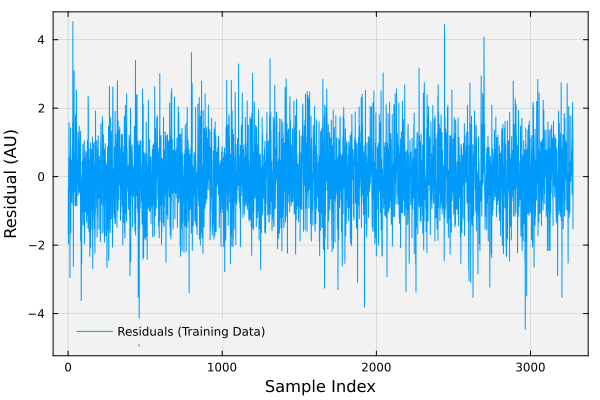

In [35]:
let

    p = vcat(γ, log(α))
    predicted_training_y_reg = training.X * p; # predicted output for the training data
    y_train = training.y;
    r = y_train .- predicted_training_y_reg;
    plot(r, label="Residuals (Training Data)")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Sample Index")
    ylabel!("Residual (AU)")
end

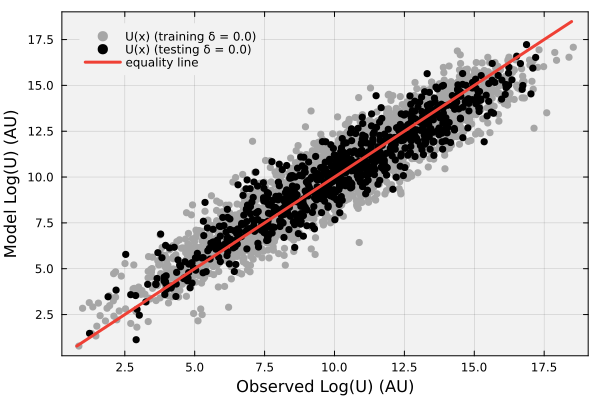

In [36]:
let

    # initialize -
    p = vcat(γ, log(α));
    p = θ̂; # use estimated parameters
    predicted_training_y_reg = training.X * p; # predicted output for the training data
    predicted_testing_y_reg = testing.X * p; # predicted output for the testing data

    # initialize -
    y_train = training.y;
    ŷ_train = predicted_training_y_reg;
    y_test = testing.y;
    ŷ_test = predicted_testing_y_reg;

    dv = [ŷ_train ; y_train ; ŷ_test ; y_test];
    L = minimum(dv);
    U = maximum(dv);
    xy_line = L:0.1:U |> collect; 

    scatter(y_train,ŷ_train,label="U(x) (training δ = $(δ))",c=:gray65, msc=:gray65)
    scatter!(y_test,ŷ_test,label="U(x) (testing δ = $(δ))",c=:black, msc=:black)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035")
    

    xlabel!("Observed Log(U) (AU)", fontsize=18)
    ylabel!("Model Log(U) (AU)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

## Task 3: Cross-Validation to Estimate Optimal Regularization Parameter
In this task, we'll implement a cross-validation algorithm to estimate the optimal regularization parameter `δ`. Cross-validation is a technique used to assess how the results of a statistical analysis will generalize to an independent dataset. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

> **K-Fold Cross-Validation Algorithm**
>
> In **k-fold cross-validation**, we partition the training data $\mathcal{D}_{\text{train}}$ into $k$ equally-sized disjoint subsets (folds) $\mathcal{F}_1, \mathcal{F}_2, \ldots, \mathcal{F}_k$. For each fold $j$:
> 1. Use fold $\mathcal{F}_j$ as the validation set
> 2. Train the model on the remaining $k-1$ folds: $\mathcal{D}_{\text{train}} \setminus \mathcal{F}_j$
> 3. Compute the mean squared error (MSE) on the validation fold $\mathcal{F}_j$
>
> We repeat this process for all $k$ folds and compute the average validation error:
> $$\text{CV}_k(\delta) = \frac{1}{k}\sum_{j=1}^{k} \text{MSE}_j(\delta)$$
> where $\text{MSE}_j(\delta)$ is the mean squared error on fold $j$ for regularization parameter $\delta$.
>
> **Optimal Parameter Selection**: We test multiple candidate values $\{\delta_1, \delta_2, \ldots, \delta_m\}$ and select:
> $$\delta^{\star} = \arg\min_{\delta \in \{\delta_1, \ldots, \delta_m\}} \text{CV}_k(\delta)$$
> This systematic approach finds the regularization strength that balances bias (underfitting from too much regularization) and variance (overfitting from too little regularization).

Let's implement this algorithm step by step.

First, let's define the range of regularization parameters we want to test. We'll use a logarithmic scale to cover several orders of magnitude, from very weak regularization ($\delta = 10^{-3}$) to very strong regularization ($\delta = 10^{3}$):



In [37]:
δ_values = 10.0 .^ range(-3, 3, length=50); # test δ from 0.001 to 1000

Now, let's implement the k-fold cross-validation algorithm. For each candidate $\delta$ value, we'll:
1. Randomly shuffle and partition the training data into `k = 100` folds
2. For each fold, train on the other $k-1$ folds and validate on the held-out fold
3. Compute the mean squared error (MSE) for each validation fold
4. Store the mean and standard deviation of MSE across all folds

We'll save the results in the `cv_results` named tuple with fields `δ_values`, `mean_errors`, and `std_errors`:

In [38]:
cv_results = let

    # initialize -
    X_train = training.X;
    y_train = training.y;
    n_samples = size(X_train, 1);
    n_params = size(X_train, 2);
    k = 100; # number of folds
    
    # Shuffle the indices
    shuffled_indices = randperm(n_samples);
    
    # Calculate fold size
    fold_size = div(n_samples, k); # rounded division
    
    # Store results for each δ
    mean_cv_errors = zeros(length(δ_values)); # mean MSE for each δ
    std_cv_errors = zeros(length(δ_values)); # std of MSE for each δ
    
    # Loop over each regularization parameter
    for (idx, δ_test) in enumerate(δ_values)
        
        # Store MSE for each fold
        fold_errors = zeros(k);
        
        # Perform k-fold cross-validation
        for fold ∈ 1:k
            
            # Define validation indices for this fold
            val_start = (fold - 1) * fold_size + 1;
            val_end = (fold == k) ? n_samples : fold * fold_size; # last fold gets remainder
            val_indices = shuffled_indices[val_start:val_end];
            
            # Training indices are all indices except validation
            train_indices = setdiff(shuffled_indices, val_indices);
            
            # Split data into train and validation sets
            X_fold_train = X_train[train_indices, :];
            y_fold_train = y_train[train_indices];
            X_fold_val = X_train[val_indices, :];
            y_fold_val = y_train[val_indices];
            
            # Train ridge regression model on this fold
            θ_fold = inv(transpose(X_fold_train) * X_fold_train + δ_test * I(n_params)) * 
                     transpose(X_fold_train) * y_fold_train;
            
            # Predict on validation set
            y_fold_pred = X_fold_val * θ_fold;
            
            # Compute MSE for this fold
            fold_errors[fold] = mean((y_fold_val .- y_fold_pred).^2);
        end
        
        # Store mean and std of CV errors for this δ
        mean_cv_errors[idx] = mean(fold_errors);
        std_cv_errors[idx] = std(fold_errors);
    end
    
    # Return results
    (δ_values = δ_values, mean_errors = mean_cv_errors, std_errors = std_cv_errors);
end;

Now let's identify the optimal regularization parameter $\delta^{\star}$ - the value that minimizes the average cross-validation error. We'll store this in the `δ_optimal::Float64` variable:

In [39]:
δ_optimal = let
    
    # Find the index of minimum CV error
    min_idx = argmin(cv_results.mean_errors);
    
    # Get the optimal δ
    δ_opt = cv_results.δ_values[min_idx];
    
    println("Optimal regularization parameter: δ = $(round(δ_opt, digits=4))");
    println("Minimum CV error: $(round(cv_results.mean_errors[min_idx], digits=6))");
    
    δ_opt;
end

Optimal regularization parameter: δ = 1.1514
Minimum CV error: 1.089677


1.1513953993264474

Let's visualize how the cross-validation error changes as a function of the regularization parameter $\delta$. This plot will help us understand the bias-variance trade-off:

> **Interpreting the CV Error Curve**
>
> * **Left side (small $\delta$)**: Weak regularization allows the model to fit training data closely but may overfit, leading to poor generalization (high variance).
> * **Minimum point**: The optimal $\delta^{\star}$ that balances fitting the data and regularizing parameters.
> * **Right side (large $\delta$)**: Strong regularization overly constrains parameters, preventing the model from capturing true relationships (high bias).
>
> The shaded region shows the standard deviation across folds, indicating the stability of our error estimates.

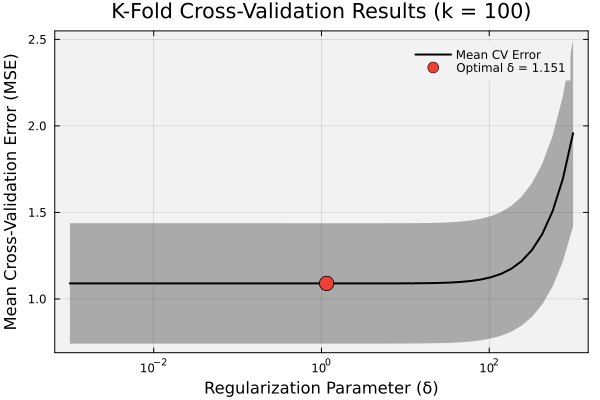

In [40]:
let
    
    # Plot mean CV error vs δ on a log scale
    plot(cv_results.δ_values, cv_results.mean_errors, 
         xscale=:log10, 
         label="Mean CV Error",
         lw=2, 
         c=:black,
         ribbon=cv_results.std_errors,
         fillalpha=0.3)
    
    # Mark the optimal δ
    scatter!([δ_optimal], [cv_results.mean_errors[argmin(cv_results.mean_errors)]], 
             label="Optimal δ = $(round(δ_optimal, digits=3))",
             c=colorant"#EF4035",
             ms=8,
             markerstroke=2)
    
    xlabel!("Regularization Parameter (δ)", fontsize=14)
    ylabel!("Mean Cross-Validation Error (MSE)", fontsize=14)
    title!("K-Fold Cross-Validation Results (k = 100)")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
end

### Train Final Model with Optimal δ
Now that we've identified the optimal regularization parameter $\delta^{\star}$, let's train a final model on the entire training set and evaluate its performance. We'll compare this optimized model against our earlier baseline model with fixed $\delta = 0.0$:

In [41]:
θ̂_optimal = let

    # initialize -
    X = training.X;
    y = training.y;
    p = size(X,2); # number of parameters

    # compute the ridge regression parameters with optimal δ -
    θ_ridge_optimal = inv(transpose(X)*X + δ_optimal*I(p))*transpose(X)*y;
    θ_ridge_optimal; # return
end;

Let's compare the parameters estimated with the optimal `δ` to the true parameters and the parameters we estimated earlier with `δ = 0.0`.

In [42]:
let 
    
    # initialize -
    df = DataFrame();
    number_of_parameters = length(θ̂_optimal);

    # build true parameter vector array -
    θ_true = vcat(γ, log(α));

    # fill the data frame -
    for i ∈ 1:number_of_parameters
        row_df = (
            Parameter = "θ[$i]",
            True = θ_true[i],
            EstimatedδFixed = θ̂[i],
            EstimatedδOptimal = θ̂_optimal[i],
            ErrorFixed = θ̂[i] - θ_true[i],
            ErrorOptimal = θ̂_optimal[i] - θ_true[i]
        );
        push!(df, row_df);
    end

    pretty_table(
         df;
         backend = :text,
         fit_table_in_display_horizontally = false,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ----------- ---------- ----------------- ------------------- ------------- --------------
  Parameter       True   EstimatedδFixed   EstimatedδOptimal    ErrorFixed   ErrorOptimal 
     String    Float64           Float64             Float64       Float64        Float64 
 ----------- ---------- ----------------- ------------------- ------------- --------------
       θ[1]    3.08296           3.07855             3.07536   -0.00440683    -0.00759682
       θ[2]    3.07443           2.97441             2.97139     -0.100021      -0.103036
       θ[3]   0.534502          0.499398            0.499576    -0.0351035     -0.0349258
       θ[4]   0.974792          0.987091            0.986594     0.0122996       0.011802
       θ[5]      2.375           2.39201             2.38974     0.0170131      0.0147368
       θ[6]    1.93424            1.9288             1.92716   -0.00544066    -0.00707274
       θ[7]   0.693147          0.781262            0.789276     0.0881148      0.0961285
 -----

Finally, let's visualize the predictions using the optimal `δ` and compare them to our earlier results.

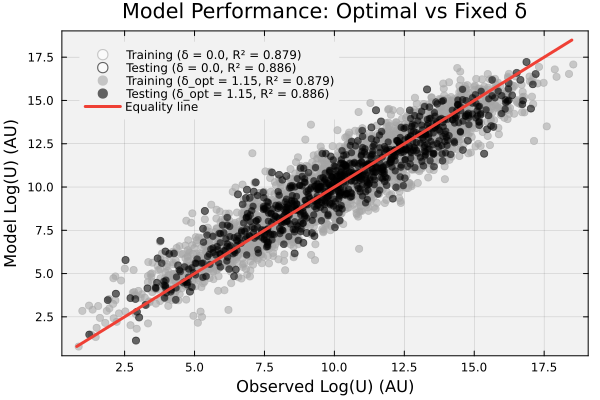

In [43]:
let

    # initialize -
    predicted_training_y_optimal = training.X * θ̂_optimal; 
    predicted_testing_y_optimal = testing.X * θ̂_optimal; 
    predicted_training_y_fixed = training.X * θ̂;
    predicted_testing_y_fixed = testing.X * θ̂;

    # data vectors -
    y_train = training.y;
    ŷ_train_opt = predicted_training_y_optimal;
    ŷ_train_fixed = predicted_training_y_fixed;
    y_test = testing.y;
    ŷ_test_opt = predicted_testing_y_optimal;
    ŷ_test_fixed = predicted_testing_y_fixed;

    # compute R² for both models
    R2_train_opt = 1 - sum((y_train .- ŷ_train_opt).^2) / sum((y_train .- mean(y_train)).^2);
    R2_test_opt = 1 - sum((y_test .- ŷ_test_opt).^2) / sum((y_test .- mean(y_test)).^2);
    R2_train_fixed = 1 - sum((y_train .- ŷ_train_fixed).^2) / sum((y_train .- mean(y_train)).^2);
    R2_test_fixed = 1 - sum((y_test .- ŷ_test_fixed).^2) / sum((y_test .- mean(y_test)).^2);

    dv = [ŷ_train_opt ; y_train ; ŷ_test_opt ; y_test];
    L = minimum(dv);
    U = maximum(dv);
    xy_line = L:0.1:U |> collect; 

    # Add fixed δ for comparison (with different marker shape)
    scatter(y_train, ŷ_train_fixed, 
            label="Training (δ = $(δ), R² = $(round(R2_train_fixed, digits=3)))",
            c=:white, msc=:gray65, alpha=0.6)
    scatter!(y_test, ŷ_test_fixed, 
             label="Testing (δ = $(δ), R² = $(round(R2_test_fixed, digits=3)))",
            c=:white, msc=:black, alpha=0.6)

    # Plot with optimal δ
    scatter!(y_train, ŷ_train_opt, 
            label="Training (δ_opt = $(round(δ_optimal, digits=2)), R² = $(round(R2_train_opt, digits=3)))",
            c=:gray65, msc=:gray65, alpha=0.6)
    scatter!(y_test, ŷ_test_opt, 
             label="Testing (δ_opt = $(round(δ_optimal, digits=2)), R² = $(round(R2_test_opt, digits=3)))",
             c=:black, msc=:black, alpha=0.6)
    

    
    plot!(xy_line, xy_line, lw=3, label="Equality line", c=colorant"#EF4035")
    
    xlabel!("Observed Log(U) (AU)", fontsize=14)
    ylabel!("Model Log(U) (AU)", fontsize=14)
    title!("Model Performance: Optimal vs Fixed δ")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, 
          fg_legend = :transparent, legend=:topleft, legendfontsize=8)
end

___
## Summary
In this lab, we implemented k-fold cross-validation to estimate the optimal regularization parameter for Ridge Regression. We systematically tested different values of `δ` to find the one that minimizes prediction error on held-out validation data.

> **Key takeaways:**
> * **Cross-validation prevents overfitting through systematic validation.** We implemented k-fold cross-validation to split training data into multiple folds, training on k-1 folds and validating on the remaining fold to estimate generalization error for each regularization parameter.
> * **Optimal regularization balances bias and variance.** By testing δ values across several orders of magnitude and selecting the one with minimum cross-validation error, we found the sweet spot that neither underfits (too much regularization) nor overfits (too little regularization).
> * **Data-driven hyperparameter selection improves model performance.** The cross-validation approach identified an optimal δ that produced better parameter estimates and prediction accuracy compared to an arbitrary fixed choice, as demonstrated by improved R² scores on the test set.

__Where do we go from here?__ Cross-validation is a fundamental technique in machine learning that extends beyond Ridge Regression. The same approach can be used to tune hyperparameters for other regularization methods (Lasso, Elastic Net), neural networks, or any model with tunable parameters. Advanced variations like stratified k-fold, leave-one-out, or nested cross-validation provide even more robust performance estimation for different scenarios.
___